# Re-run of old models

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import statsmodels.api as sm

from pathlib import Path

In [2]:
from statsmodels import __version__
__version__

'0.10.1'

In [3]:
# Set up environment
pd.plotting.register_matplotlib_converters()
np.random.seed(42)

In [4]:
path_data = Path(".").absolute().parent / "data"
path_xl = path_data / "ESI_GDP.xlsx"

In [5]:
path_output = Path(".").absolute().parent / "output" / pd.Timestamp.utcnow().strftime("%Y-%m-%d")
path_output.mkdir(exist_ok=True, parents=True)

# Load data

In [6]:
df = pd.read_excel(path_xl)
df.index = df.index.to_series().apply(lambda x: pd.datetime.strptime(x, '%YM%m'))
df.dropna().head()

,GGDP,GESI,GESISA,GGDPSA
2006-05-01,110.800000,106.863298,106.816640,109.458524
2006-06-01,109.258365,106.396667,106.327908,109.290571
2006-07-01,109.859167,104.883275,104.541073,109.045494
2006-08-01,108.508595,101.666480,101.486939,109.335025
2006-09-01,107.968031,99.242416,101.525884,107.570909


In [7]:
ggdp = df["GGDP"]
gesi = df["GESI"]

# Seasonal adjustment (via X13-ARIMA-SEATS)

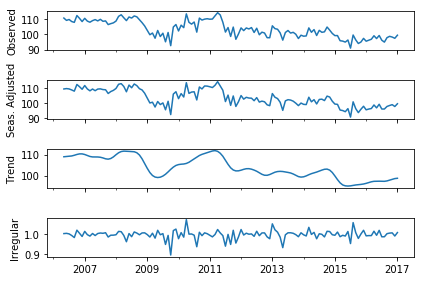

In [8]:
x13_gdp = sm.tsa.x13_arima_analysis(ggdp.dropna())
gdp_sa = x13_gdp.seasadj
x13_gdp.plot();

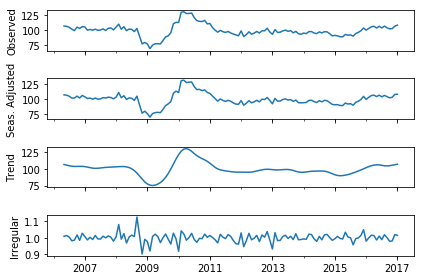

In [9]:
x13_esi = sm.tsa.x13_arima_analysis(gesi.dropna())
esi_sa = x13_esi.seasadj
x13_esi.plot();

# Modelling

## Prepare data

In [10]:
e4 = esi_sa.tshift(4)
e4.head()

2006-09-01    106.942781
2006-10-01    106.416458
2006-11-01    104.651012
2006-12-01    101.612297
2007-01-01    101.684418
Freq: MS, Name: seasadj, dtype: float64

In [11]:
data = pd.concat(
    [gdp_sa.rename("gdp_sa"), e4.rename("esi_sa_4")], axis="columns"
).dropna(axis="rows")
data['c'] = 1
data['t'] = range(len(data))
pd.concat([data.head(), data.tail()])

,gdp_sa,esi_sa_4,c,t
2006-09-01,107.818316,106.942781,1,0
2006-10-01,112.205728,106.416458,1,1
2006-11-01,110.749865,104.651012,1,2
2006-12-01,109.066078,101.612297,1,3
2007-01-01,111.526153,101.684418,1,4
2016-09-01,97.738588,104.127821,1,120
2016-10-01,98.381886,106.423659,1,121
2016-11-01,98.929566,103.613860,1,122
2016-12-01,97.712345,106.077786,1,123
2017-01-01,99.527172,104.005035,1,124


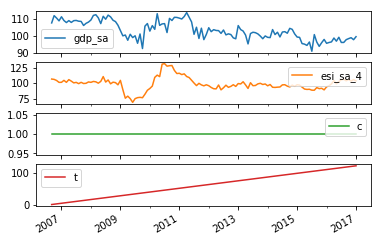

In [12]:
data.plot.line(subplots=True);

## Markov-switching Regression

In [13]:
actuals = data["gdp_sa"]

mlr =sm.tsa.MarkovRegression(
    endog=actuals, k_regimes=2, exog=data[['t', "esi_sa_4"]], 
).fit(search_reps=200, em_iter=20, disp=True)

coef = pd.DataFrame({
    'value': mlr.params,
    'std': pd.Series(np.sqrt(np.diag(mlr.cov_params())), mlr.params.index),
    'z': mlr.tvalues
})

pred_mlr = mlr.predict()
res = pd.DataFrame({
    'actual': actuals,
    'pred': pred_mlr,
    'resid': actuals - pred_mlr,
    'prob_raw': pd.Series(mlr.predicted_marginal_probabilities[0], index=data.index),
    'prob_filtered': mlr.filtered_marginal_probabilities[0],
    'prob_smoothed': mlr.smoothed_marginal_probabilities[0],
})

durbin_watson = np.round(sm.stats.stattools.durbin_watson(res.resid), 3)

res.head()

Optimization terminated successfully.
         Current function value: 2.387389
         Iterations: 49
         Function evaluations: 54
         Gradient evaluations: 54


,actual,pred,resid,prob_raw,prob_filtered,prob_smoothed
2006-09-01,107.818316,110.161732,-2.343416,0.419319,0.932796,0.954253
2006-10-01,112.205728,110.313049,1.892679,0.805892,0.743068,0.877013
2006-11-01,110.749865,110.064840,0.685025,0.663054,0.718100,0.871254
2006-12-01,109.066078,109.661271,-0.595193,0.644258,0.756794,0.874578
2007-01-01,111.526153,109.605764,1.920389,0.673388,0.565303,0.860336


### Export to Excel

In [14]:
writer = pd.ExcelWriter(path_output / "results.xlsx")
with writer:
    res.to_excel(writer, sheet_name='Results')
    coef.to_excel(writer, sheet_name='Coefficients')

### Plot

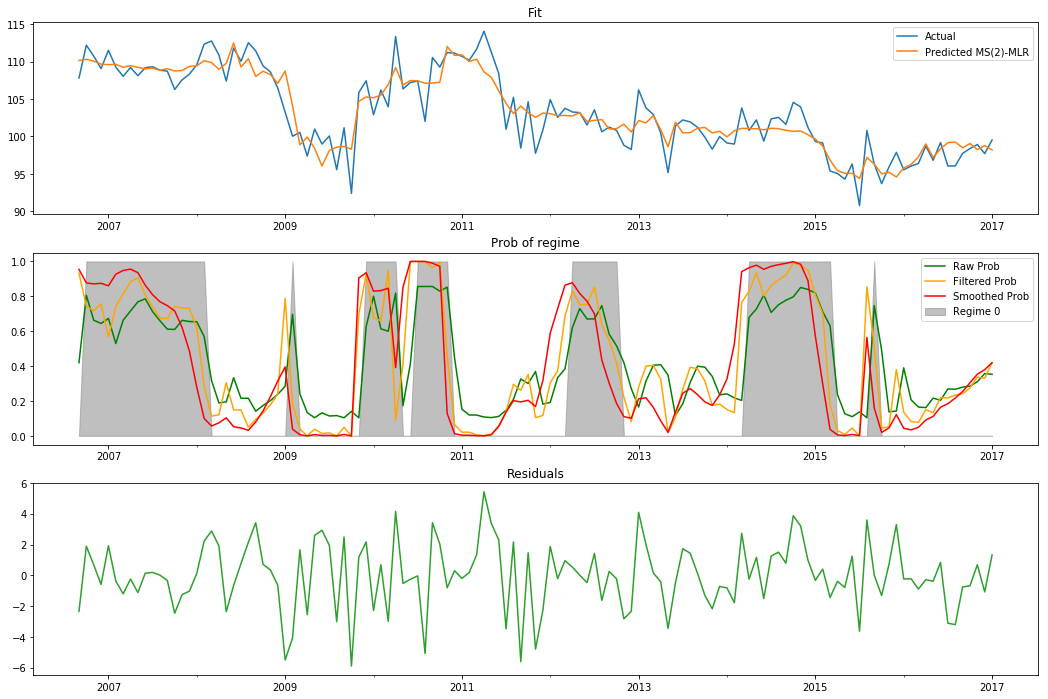

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(18, 12))

ax[0].set_title("Fit")
res.actual.plot.line(ax=ax[0], color="C0", label="Actual")
res.pred.plot.line(ax=ax[0], color="C1", label="Predicted MS(2)-MLR")
ax[0].legend()

ax[1].set_title("Prob of regime")
res.prob_raw.plot.line(ax=ax[1], color="green", label="Raw Prob")
res.prob_filtered.plot.line(ax=ax[1], color="orange", label="Filtered Prob")
res.prob_smoothed.plot.line(ax=ax[1], color="red", label="Smoothed Prob")
ax[1].fill_between(
    data.index,
    0,
    (res.prob_raw > 0.5).astype(int),
    color="grey",
    alpha=0.5,
    label="Regime 0",
)
ax[1].legend()

ax[2].set_title("Residuals")
res.resid.plot.line(ax=ax[2], color="C2")

fig.savefig(path_output / "model_fits.png")
fig;

### Model summary

Variables in the model:

- `const` is the intercept
- `x1` is the linear trend
- `x2` is the esi_sa\[-4\] variable

In [16]:
summary = mlr.summary()

# Add variable information
tbl_variables = sm.iolib.table.SimpleTable(
    [
        ['const', 'Intercept term'],
        ['x1', 'Linear trend (t)'],
        ['x2', 'GESI_SA[-4] (seasonally adjusted by X13)']
    ],
    headers=["Variable", "Name"], title='Variable information'
)
summary.tables.insert(1, tbl_variables)

# Add regime information
tbl_regimes = sm.iolib.table.SimpleTable(
    [[i, np.round(mlr.expected_durations[i], 3)] for i in range(2)],
    headers=["Regime", "Expected Duration"], title='Other regime information'
)
summary.tables.append(tbl_regimes)

# Other 
tbl_other_stats = sm.iolib.table.SimpleTable(
    [
        ['Durbin-Watson', durbin_watson],
    ],
    headers=["Statistic", "Value"], title='Other statistics'
)
summary.tables.append(tbl_other_stats)

# Get rid of warning text at end
summary.add_extra_txt([])

# Write to file
with (path_output / "summary.txt").open("w") as f:
    f.write(summary.as_text())

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 gdp_sa   No. Observations:                  125
Model:               MarkovRegression   Log Likelihood                -298.424
Date:                Sun, 02 Feb 2020   AIC                            614.847
Time:                        18:36:40   BIC                            640.302
Sample:                    09-01-2006   HQIC                           625.188
                         - 01-01-2017                                         
Covariance Type:               approx                                         
               Variable information              
=================================================
Variable                   Name                  
-------------------------------------------------
   const                           Intercept term
      x1                         Linear trend (t)
      x2 GESI_SA[-4] (seasonally adjusted by X13)
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5166      3.889     26.615      0.000      95.893     111.140
x1            -0.0879      0.016     -5.579      0.000      -0.119      -0.057
x2             0.0605      0.036      1.682      0.093      -0.010       0.131
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.3700      3.238     22.966      0.000      68.023      80.717
x1            -0.1212      0.011    -10.668      0.000      -0.143      -0.099
x2             0.3688      0.035     10.489      0.000       0.300       0.438
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.2727      0.936      5.634      0.000       3.438       7.107
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8565      0.090      9.534      0.000       0.680       1.033
p[1->0]        0.1036      0.087      1.194      0.233      -0.067       0.274
Other regime information
========================
Regime Expected Duration
------------------------
     0             6.968
     1             9.649
  Other statistics 
===================
  Statistic   Value
-------------------
Durbin-Watson 2.029
-------------------


"""

### Residual Diagnostics

In [17]:
durbin_watson

2.029

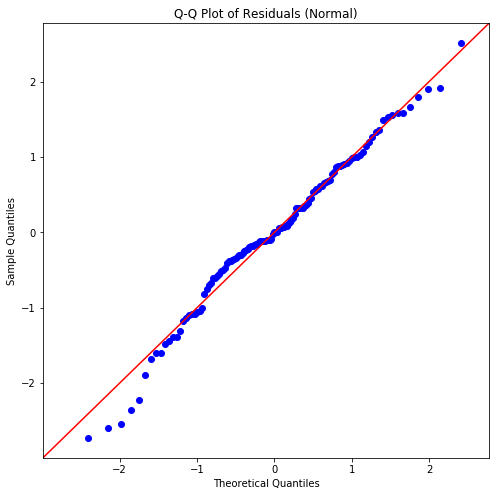

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title("Q-Q Plot of Residuals (Normal)")
sm.graphics.qqplot(res.resid / np.std(res.resid), line="45", ax=ax)
fig.savefig(path_output / "resid_qq.png")

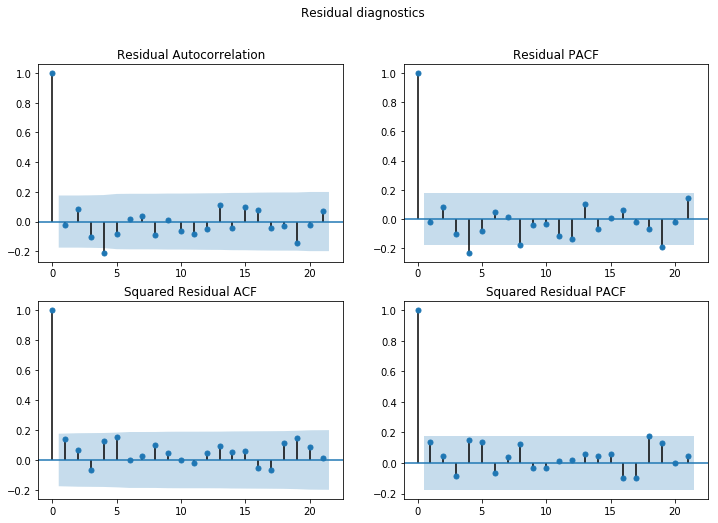

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sm.tsa.graphics.plot_acf(res.resid, ax=ax[0,0], title='Residual Autocorrelation')
sm.tsa.graphics.plot_pacf(res.resid, ax=ax[0,1], title='Residual PACF')
sm.tsa.graphics.plot_acf(res.resid**2, ax=ax[1,0], title='Squared Residual ACF')
sm.tsa.graphics.plot_pacf(res.resid**2, ax=ax[1,1], title='Squared Residual PACF')
fig.suptitle("Residual diagnostics")

fig.savefig(path_output / "resid_acf.png")
fig;